In [ ]:
# For each Landsat:
# 1. Load DF
# 2. Plot average of all points that overlap with Singapore on the plot
# 3. Store averages for each year in a dataframe

# Landsat 5, 7, 8, 9:
# 1. Append all DFs, plot from 1990 onwards
# 2. Plot average across all years

Analysis for LST over time, no clear increase from 1999 onwards
- Computationally extensive to concatenate data from all years, unable to elicit clear trends

In [ ]:
import geopandas as gpd
import pandas as pd
import os
import zipfile
from datetime import datetime
import shutil
import rasterio
import numpy as np
from pyproj import Transformer
import matplotlib.pyplot as plt
import warnings

# Landsat 9

In [8]:
# Setup paths
data_dir = "C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data"
singapore_geojson_path = os.path.join(data_dir, "singapore-boundary.geojson")
landsat_dir = os.path.join(data_dir, "Landsat9")
temp_dir = os.path.join(data_dir, "temp_extract")

# Ensure temporary directory exists
os.makedirs(temp_dir, exist_ok=True)

# Suppress specific FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Filtering conditions
qa_pixel_filter_1 = [5504, 5506, 54534, 54790, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 54852, 24144, 23888, 56660, 56916]
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

def preprocessing_sg(file_path, singapore_geojson_path):
    print(f"Processing file: {file_path}")
    with rasterio.open(file_path) as src:
        array = src.read()
        transform = src.transform
        transformer = Transformer.from_crs(src.crs, 'EPSG:4326', always_xy=True)
        cols, rows = np.meshgrid(np.arange(array.shape[2]), np.arange(array.shape[1]))
        xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')
        lon, lat = transformer.transform(np.array(xs).flatten(), np.array(ys).flatten())
        
        df = pd.DataFrame({'Longitude': lon, 'Latitude': lat})
        for i, band in enumerate(src.read(masked=True)):
            df[src.descriptions[i]] = band.flatten()

        df['ST_B10_Celsius'] = df['ST_B10'] * 0.00341802 + 149 - 273.15
        df = df[df['ST_B10_Celsius'] >= 20]
        
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.set_crs('EPSG:4326', inplace=True)
        
        singapore_boundary = gpd.read_file(singapore_geojson_path)
        singapore_boundary = singapore_boundary.to_crs('EPSG:4326')
        
        # Use predicate instead of op
        filtered_gdf = gpd.sjoin(gdf, singapore_boundary, how="inner", predicate='within')
        return filtered_gdf

# Process all years
gdfs_landsat9 = []
for year in range(2021, 2025):
    print(f"Processing year: {year}")
    zip_file_path = os.path.join(landsat_dir, f"{year}.zip")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    year_dir = os.path.join(temp_dir, str(year))
    for filename in os.listdir(year_dir):
        if filename.endswith(".tif"):
            file_path = os.path.join(year_dir, filename)
            time_str = filename.split('_')[2]
            time_obj = datetime.strptime(time_str, "%Y%m%d")
            
            gdf = preprocessing_sg(file_path, singapore_geojson_path)
            gdf['time'] = time_obj
            gdfs_landsat9.append(gdf)

Processing year: 2021
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2021\L9_UTC_20211031_031441.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2021\L9_UTC_20211105_031711.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2021\L9_UTC_20211110_031939.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2021\L9_UTC_20211115_032207.tif
Processing year: 2022
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2022\L9_UTC_20220119_031653.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2022\L9_UTC_20220204_031654.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2022\L9_UTC_20220220_031646.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\M

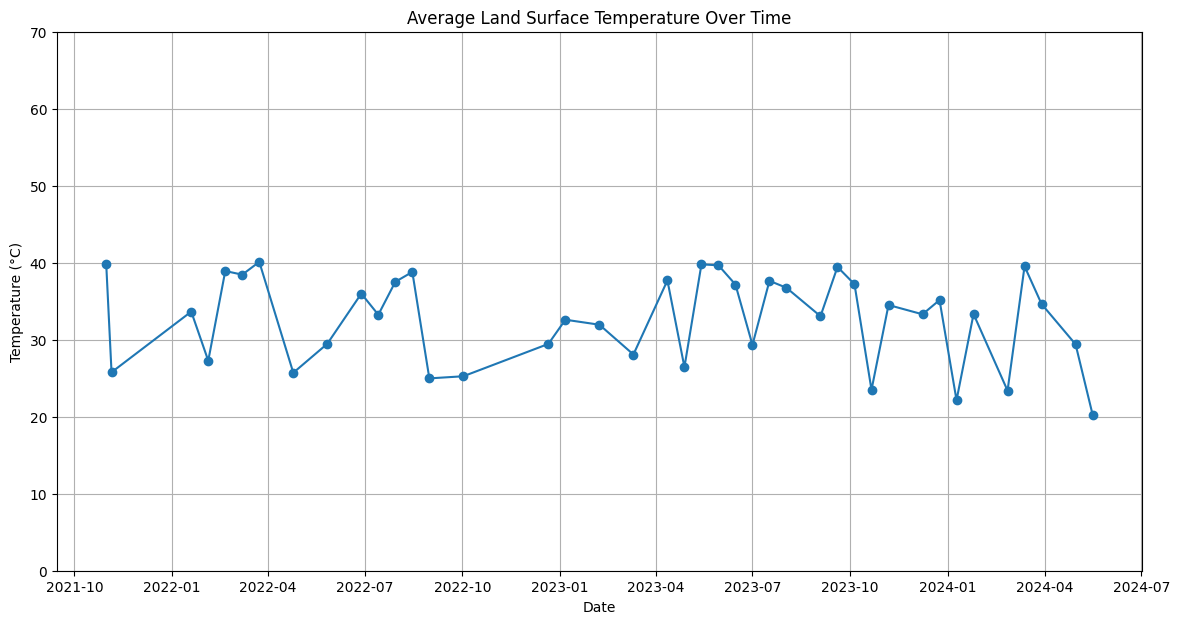

In [3]:
# # Filtering valid pixels after preprocessing
# filtered_gdfs_landsat9 = []
# for gdf in gdfs_landsat9:
#     gdf_filtered = gdf[~gdf['QA_PIXEL'].isin(qa_pixel_filter_1)]
#     filtered_gdfs_landsat9.append(gdf_filtered)

# # Combine and calculate average LST
# landsat9_combined_gdf = pd.concat(filtered_gdfs_landsat9)
# average_lst_landsat9 = landsat9_combined_gdf.groupby(landsat9_combined_gdf['time'].dt.date)['ST_B10_Celsius'].mean().reset_index()

# # Cleanup temporary directory
# shutil.rmtree(temp_dir)

# # Plotting
# plt.figure(figsize=(14, 7))
# plt.plot(average_lst_landsat9['time'], average_lst_landsat9['ST_B10_Celsius'], marker='o')
# plt.title('Average Land Surface Temperature Over Time')
# plt.xlabel('Date')
# plt.ylabel('Temperature (°C)')
# plt.ylim(0, 70)
# plt.grid(True)
# plt.show()

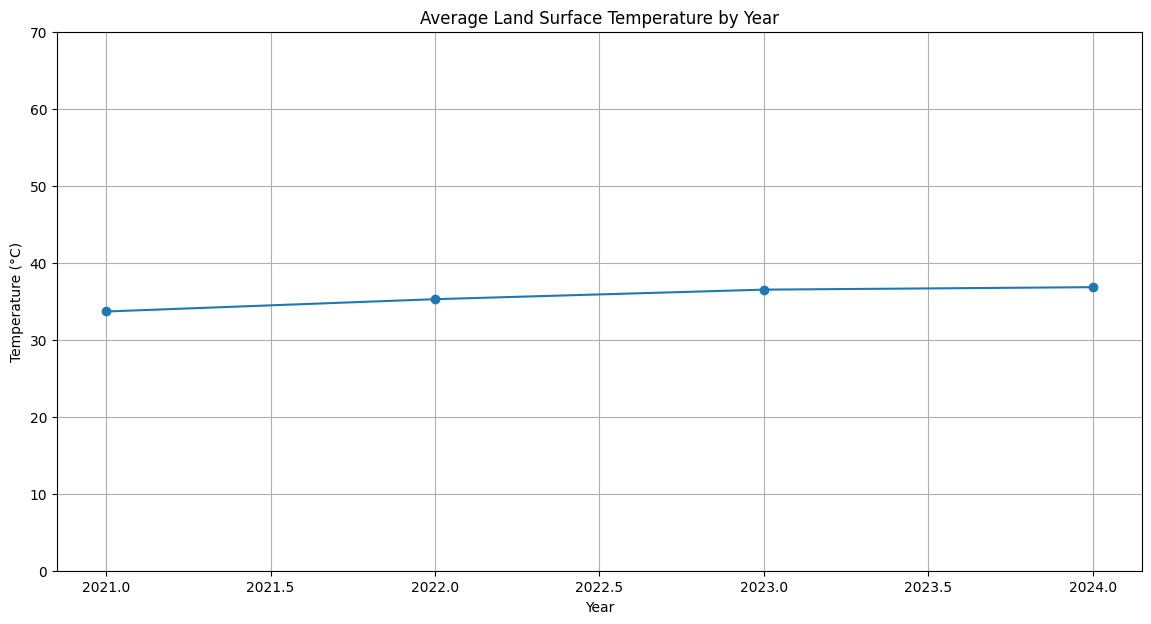

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import shutil

# Assuming gdfs_landsat7 is a list of GeoDataFrames with 'time' and 'ST_B6_Celsius' columns
# and qa_pixel_filter_1 has been defined to filter QA_PIXEL values

# Filtering valid pixels after preprocessing
filtered_gdfs_landsat9 = []
for gdf in gdfs_landsat9:
    gdf_filtered = gdf[~gdf['QA_PIXEL'].isin(qa_pixel_filter_1)]
    filtered_gdfs_landsat9.append(gdf_filtered)

# Combine all filtered GeoDataFrames into one
landsat9_combined_gdf = pd.concat(filtered_gdfs_landsat9)

# Ensure 'time' is in datetime format
landsat9_combined_gdf['time'] = pd.to_datetime(landsat9_combined_gdf['time'])

# Group by year to calculate average LST
landsat9_combined_gdf['year'] = landsat9_combined_gdf['time'].dt.year
average_lst_by_year = landsat9_combined_gdf.groupby('year')['ST_B10_Celsius'].mean().reset_index()

# Assuming the cleanup of a temporary directory
shutil.rmtree(temp_dir)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(average_lst_by_year['year'], average_lst_by_year['ST_B10_Celsius'], marker='o', linestyle='-')
plt.title('Average Land Surface Temperature by Year')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.ylim(0, 70)
plt.grid(True)
plt.show()

# Landsast 8

In [6]:
import geopandas as gpd
import pandas as pd
import os
import zipfile
from datetime import datetime
import shutil
import rasterio
import numpy as np
from pyproj import Transformer
import matplotlib.pyplot as plt
import warnings

# Setup paths
data_dir = "C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data"
singapore_geojson_path = os.path.join(data_dir, "singapore-boundary.geojson")
landsat_dir = os.path.join(data_dir, "Landsat8")
temp_dir = os.path.join(data_dir, "temp_extract")

# Ensure temporary directory exists
os.makedirs(temp_dir, exist_ok=True)

# Suppress specific FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Filtering conditions
qa_pixel_filter_1 = [5504, 5506, 54534, 54790, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 54852, 24144, 23888, 56660, 56916]
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

def preprocessing_sg(file_path, singapore_geojson_path):
    print(f"Processing file: {file_path}")
    with rasterio.open(file_path) as src:
        array = src.read()
        transform = src.transform
        transformer = Transformer.from_crs(src.crs, 'EPSG:4326', always_xy=True)
        cols, rows = np.meshgrid(np.arange(array.shape[2]), np.arange(array.shape[1]))
        xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')
        lon, lat = transformer.transform(np.array(xs).flatten(), np.array(ys).flatten())
        
        df = pd.DataFrame({'Longitude': lon, 'Latitude': lat})
        for i, band in enumerate(src.read(masked=True)):
            df[src.descriptions[i]] = band.flatten()

        df['ST_B10_Celsius'] = df['ST_B10'] * 0.00341802 + 149 - 273.15
        df = df[df['ST_B10_Celsius'] >= 20]
        
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.set_crs('EPSG:4326', inplace=True)
        
        singapore_boundary = gpd.read_file(singapore_geojson_path)
        singapore_boundary = singapore_boundary.to_crs('EPSG:4326')
        
        # Use predicate instead of op
        filtered_gdf = gpd.sjoin(gdf, singapore_boundary, how="inner", predicate='within')
        return filtered_gdf

# Process all years
gdfs_landsat8 = []
for year in range(2014, 2025):
    print(f"Processing year: {year}")
    zip_file_path = os.path.join(landsat_dir, f"{year}.zip")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    year_dir = os.path.join(temp_dir, str(year))
    for filename in os.listdir(year_dir):
        if filename.endswith(".tif"):
            file_path = os.path.join(year_dir, filename)
            time_str = filename.split('_')[2]
            time_obj = datetime.strptime(time_str, "%Y%m%d")
            
            gdf = preprocessing_sg(file_path, singapore_geojson_path)
            gdf['time'] = time_obj
            gdfs_landsat8.append(gdf)

Processing year: 2014
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2014\L8_UTC_20140121_031746.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2014\L8_UTC_20140206_031737.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2014\L8_UTC_20140222_031724.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2014\L8_UTC_20140310_031711.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2014\L8_UTC_20140326_031655.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2014\L8_UTC_20140411_031642.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2014\L8_UTC_20140427_031626.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-

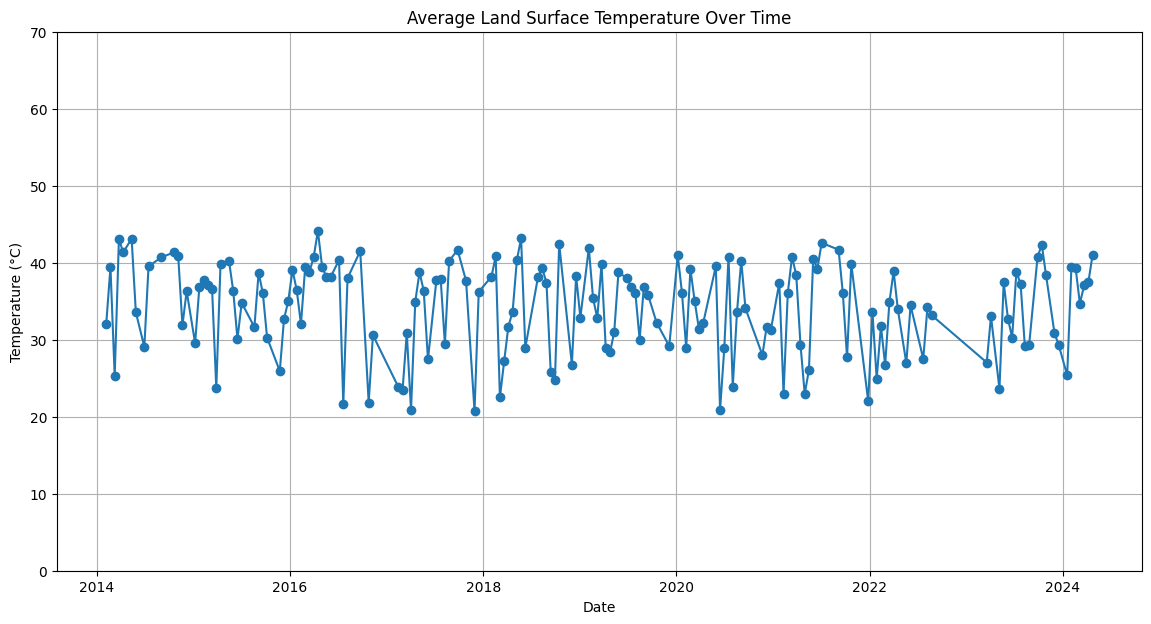

In [5]:
# # Filtering valid pixels after preprocessing
# filtered_gdfs_landsat8 = []
# for gdf in gdfs_landsat8:
#     gdf_filtered = gdf[~gdf['QA_PIXEL'].isin(qa_pixel_filter_1)]
#     filtered_gdfs_landsat8.append(gdf_filtered)

# # Combine and calculate average LST
# landsat8_combined_gdf = pd.concat(filtered_gdfs_landsat8)
# average_lst_landsat8 = landsat8_combined_gdf.groupby(landsat8_combined_gdf['time'].dt.date)['ST_B10_Celsius'].mean().reset_index()

# # Cleanup temporary directory
# shutil.rmtree(temp_dir)

# # Plotting
# plt.figure(figsize=(14, 7))
# plt.plot(average_lst_landsat8['time'], average_lst_landsat8['ST_B10_Celsius'], marker='o')
# plt.title('Average Land Surface Temperature Over Time')
# plt.xlabel('Date')
# plt.ylabel('Temperature (°C)')
# plt.ylim(0, 70)
# plt.grid(True)
# plt.show()

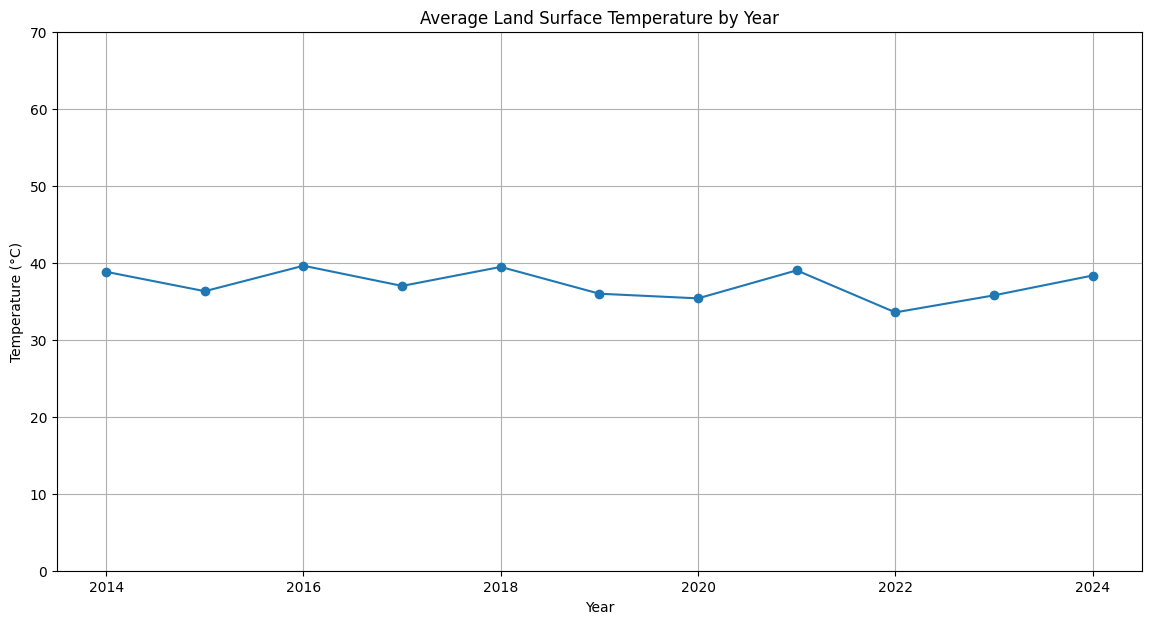

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import shutil

# Assuming gdfs_landsat7 is a list of GeoDataFrames with 'time' and 'ST_B6_Celsius' columns
# and qa_pixel_filter_1 has been defined to filter QA_PIXEL values

# Filtering valid pixels after preprocessing
filtered_gdfs_landsat8 = []
for gdf in gdfs_landsat8:
    gdf_filtered = gdf[~gdf['QA_PIXEL'].isin(qa_pixel_filter_1)]
    filtered_gdfs_landsat8.append(gdf_filtered)

# Combine all filtered GeoDataFrames into one
landsat8_combined_gdf = pd.concat(filtered_gdfs_landsat8)

# Ensure 'time' is in datetime format
landsat8_combined_gdf['time'] = pd.to_datetime(landsat8_combined_gdf['time'])

# Group by year to calculate average LST
landsat8_combined_gdf['year'] = landsat8_combined_gdf['time'].dt.year
average_lst_by_year = landsat8_combined_gdf.groupby('year')['ST_B10_Celsius'].mean().reset_index()

# Assuming the cleanup of a temporary directory
shutil.rmtree(temp_dir)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(average_lst_by_year['year'], average_lst_by_year['ST_B10_Celsius'], marker='o', linestyle='-')
plt.title('Average Land Surface Temperature by Year')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.ylim(0, 70)
plt.grid(True)
plt.show()

In [ ]:
import os
import geopandas as gpd

# Specify the file path where the Parquet file will be saved
file_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Parquets\1999_to_2022_landsat8.parquet"

# Ensure the directory exists
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Save the GeoDataFrame to a Parquet file
landsat8_combined_gdf.to_parquet(file_path, index=False)

print(f"Dataframe saved to {file_path}")

# Landsat 7

In [4]:
import geopandas as gpd
import pandas as pd
import os
import zipfile
from datetime import datetime
import shutil
import rasterio
import numpy as np
from pyproj import Transformer
import matplotlib.pyplot as plt
import warnings

# Setup paths
data_dir = "C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data"
singapore_geojson_path = os.path.join(data_dir, "singapore-boundary.geojson")
landsat_dir = os.path.join(data_dir, "Landsat7")
temp_dir = os.path.join(data_dir, "temp_extract")

# Ensure temporary directory exists
os.makedirs(temp_dir, exist_ok=True)

# Suppress specific FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Filtering conditions
qa_pixel_filter_1 = [5504, 5506, 54534, 54790, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 54852, 24144, 23888, 56660, 56916]
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

def preprocessing_sg(file_path, singapore_geojson_path):
    print(f"Processing file: {file_path}")
    with rasterio.open(file_path) as src:
        array = src.read()
        transform = src.transform
        transformer = Transformer.from_crs(src.crs, 'EPSG:4326', always_xy=True)
        cols, rows = np.meshgrid(np.arange(array.shape[2]), np.arange(array.shape[1]))
        xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')
        lon, lat = transformer.transform(np.array(xs).flatten(), np.array(ys).flatten())
        
        df = pd.DataFrame({'Longitude': lon, 'Latitude': lat})
        for i, band in enumerate(src.read(masked=True)):
            df[src.descriptions[i]] = band.flatten()

        df['ST_B6_Celsius'] = df['ST_B6'] * 0.00341802 + 149 - 273.15
        df = df[df['ST_B6_Celsius'] >= 20]
        
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.set_crs('EPSG:4326', inplace=True)
        
        singapore_boundary = gpd.read_file(singapore_geojson_path)
        singapore_boundary = singapore_boundary.to_crs('EPSG:4326')
        
        # Use predicate instead of op
        filtered_gdf = gpd.sjoin(gdf, singapore_boundary, how="inner", predicate='within')
        return filtered_gdf

# Process all years
gdfs_landsat7 = []
for year in range(1999, 2023):
    print(f"Processing year: {year}")
    zip_file_path = os.path.join(landsat_dir, f"{year}.zip")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    year_dir = os.path.join(temp_dir, str(year))
    for filename in os.listdir(year_dir):
        if filename.endswith(".tif"):
            file_path = os.path.join(year_dir, filename)
            time_str = filename.split('_')[2]
            time_obj = datetime.strptime(time_str, "%Y%m%d")
            
            gdf = preprocessing_sg(file_path, singapore_geojson_path)
            gdf['time'] = time_obj
            gdfs_landsat7.append(gdf)

Processing year: 1999
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\1999\L7_UTC_19990901_030935.tif
Processing year: 2000
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2000\L7_UTC_20000428_030856.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2000\L7_UTC_20000530_030834.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2000\L7_UTC_20000717_030804.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2000\L7_UTC_20000903_030727.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2000\L7_UTC_20001106_030658.tif
Processing file: C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract\2000\L7_UTC_20001208_030658.tif
Processing year: 2001
Processing file: C:\LocalOneDri

In [ ]:
# Filtering valid pixels after preprocessing
filtered_gdfs_landsat7 = []
for gdf in gdfs_landsat7:
    gdf_filtered = gdf[~gdf['QA_PIXEL'].isin(qa_pixel_filter_1)]
    filtered_gdfs_landsat7.append(gdf_filtered)

# Combine and calculate average LST
landsat7_combined_gdf = pd.concat(filtered_gdfs_landsat7)
average_lst_landsat7 = landsat7_combined_gdf.groupby(landsat7_combined_gdf['time'].dt.date)['ST_B6_Celsius'].mean().reset_index()

# Cleanup temporary directory
shutil.rmtree(temp_dir)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(average_lst_landsat7['time'], average_lst_landsat7['ST_B6_Celsius'], marker='o')
plt.title('Average Land Surface Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.ylim(0, 70)
plt.grid(True)
plt.show()

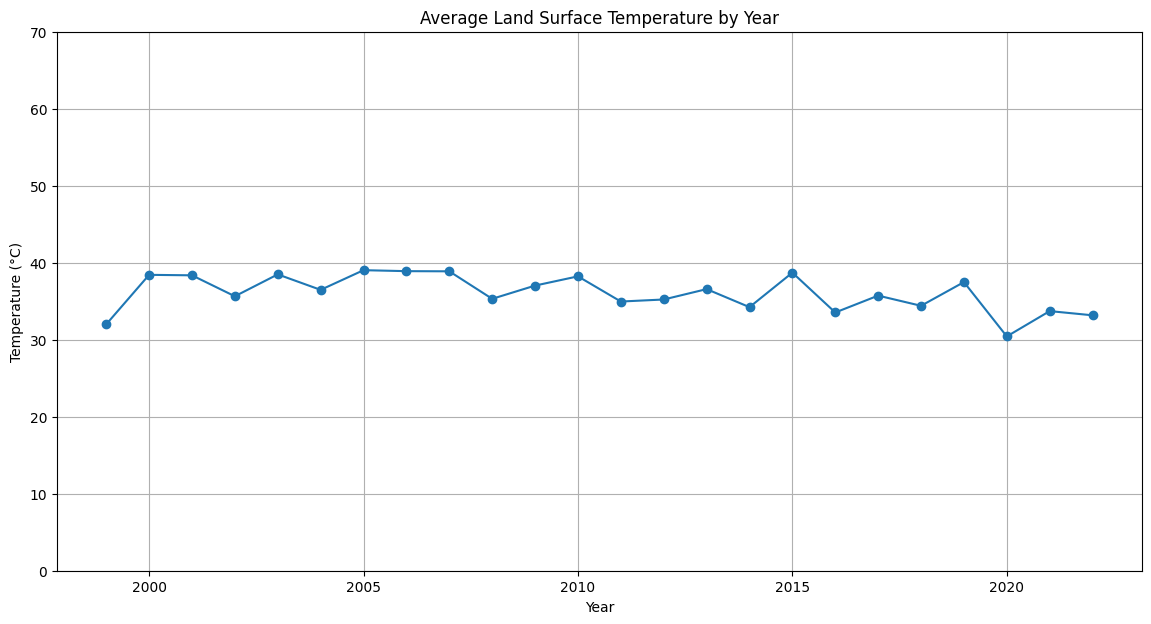

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import shutil

# Assuming gdfs_landsat7 is a list of GeoDataFrames with 'time' and 'ST_B6_Celsius' columns
# and qa_pixel_filter_1 has been defined to filter QA_PIXEL values

# Filtering valid pixels after preprocessing
filtered_gdfs_landsat7 = []
for gdf in gdfs_landsat7:
    gdf_filtered = gdf[~gdf['QA_PIXEL'].isin(qa_pixel_filter_1)]
    filtered_gdfs_landsat7.append(gdf_filtered)

# Combine all filtered GeoDataFrames into one
landsat7_combined_gdf = pd.concat(filtered_gdfs_landsat7)

# Ensure 'time' is in datetime format
landsat7_combined_gdf['time'] = pd.to_datetime(landsat7_combined_gdf['time'])

# Group by year to calculate average LST
landsat7_combined_gdf['year'] = landsat7_combined_gdf['time'].dt.year
average_lst_by_year = landsat7_combined_gdf.groupby('year')['ST_B6_Celsius'].mean().reset_index()

# Assuming the cleanup of a temporary directory
shutil.rmtree(temp_dir)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(average_lst_by_year['year'], average_lst_by_year['ST_B6_Celsius'], marker='o', linestyle='-')
plt.title('Average Land Surface Temperature by Year')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.ylim(0, 70)
plt.grid(True)
plt.show()

In [7]:
import os
import geopandas as gpd

# Specify the file path where the Parquet file will be saved
file_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Parquets\1999_to_2022_landsat7.parquet"

# Ensure the directory exists
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Save the GeoDataFrame to a Parquet file
landsat7_combined_gdf.to_parquet(file_path, index=False)

print(f"Dataframe saved to {file_path}")

Dataframe saved to C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Parquets\1999_to_2022_landsat7.parquet


# LST across 1999 - 2024

In [16]:
landsat7_combined_gdf.drop(columns=['LST_Celsius'], inplace=True)
landsat8_combined_gdf.drop(columns=['LST_Celsius'], inplace=True)
landsat9_combined_gdf.drop(columns=['LST_Celsius'], inplace=True)

MemoryError: Unable to allocate 795. MiB for an array with shape (2, 52087991) and data type float64

In [14]:
# Create 'LST_Celsius' for Landsat 7 from 'ST_B6_Celsius'
landsat7_combined_gdf['LST_Celsius'] = landsat7_combined_gdf['ST_B6_Celsius']

# Create 'LST_Celsius' for Landsat 8 from 'ST_B10_Celsius'
landsat8_combined_gdf['LST_Celsius'] = landsat8_combined_gdf['ST_B10_Celsius']

# Create 'LST_Celsius' for Landsat 9 from 'ST_B10_Celsius'
landsat9_combined_gdf['LST_Celsius'] = landsat9_combined_gdf['ST_B10_Celsius']

In [15]:
import pandas as pd

# Concatenate the dataframes
all_landsat_data = pd.concat([landsat7_combined_gdf, landsat8_combined_gdf, landsat9_combined_gdf], ignore_index=True)

MemoryError: Unable to allocate 398. MiB for an array with shape (1, 104379699) and data type float32